# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

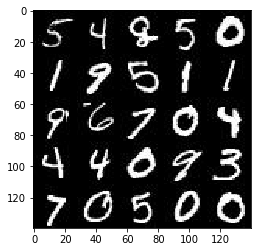

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

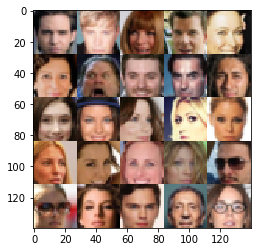

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1

    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14 x 14 x 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7 x 7 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)        
        #4 x 4 x 256
        
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #4 x 4 512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #7 x 7 x 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #14 x 14 x 128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #28 x 28 x out_channel_dim
    
        out = tf.tanh(logits)        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[-1], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    n_images = 25
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2. #value of images are -0.5 ~ 0.5
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[-1], data_image_mode)
        
        print("\ngenerator output after trainings")
        show_generator_output(sess, n_images, input_z, data_shape[-1], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4307... Generator Loss: 5.4082
Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 0.4018
Epoch 1/2... Discriminator Loss: 0.5767... Generator Loss: 2.2801
Epoch 1/2... Discriminator Loss: 2.7299... Generator Loss: 0.1105
Epoch 1/2... Discriminator Loss: 0.6371... Generator Loss: 7.3068
Epoch 1/2... Discriminator Loss: 0.7008... Generator Loss: 6.2212
Epoch 1/2... Discriminator Loss: 0.5188... Generator Loss: 2.4316
Epoch 1/2... Discriminator Loss: 0.3903... Generator Loss: 4.9344
Epoch 1/2... Discriminator Loss: 0.3942... Generator Loss: 3.6459
Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 3.2564


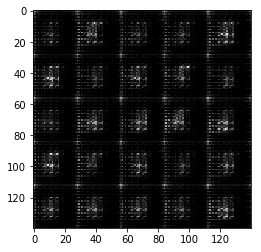

Epoch 1/2... Discriminator Loss: 0.3980... Generator Loss: 3.8280
Epoch 1/2... Discriminator Loss: 0.4029... Generator Loss: 3.2226
Epoch 1/2... Discriminator Loss: 0.5335... Generator Loss: 2.4420
Epoch 1/2... Discriminator Loss: 0.5280... Generator Loss: 2.4159
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 2.0273
Epoch 1/2... Discriminator Loss: 0.6726... Generator Loss: 1.7955
Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 2.4076
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.4763
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 1.7917
Epoch 1/2... Discriminator Loss: 0.9735... Generator Loss: 4.0335


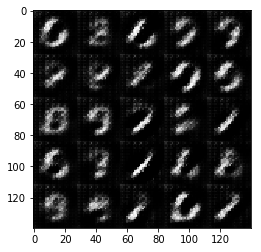

Epoch 1/2... Discriminator Loss: 0.5604... Generator Loss: 2.5090
Epoch 1/2... Discriminator Loss: 0.5595... Generator Loss: 2.2401
Epoch 1/2... Discriminator Loss: 1.8990... Generator Loss: 5.4308
Epoch 1/2... Discriminator Loss: 0.6783... Generator Loss: 2.4339
Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 2.6820
Epoch 1/2... Discriminator Loss: 0.6653... Generator Loss: 2.1123
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 1.6973
Epoch 1/2... Discriminator Loss: 0.7726... Generator Loss: 1.9150
Epoch 1/2... Discriminator Loss: 0.7492... Generator Loss: 2.0748
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 2.0812


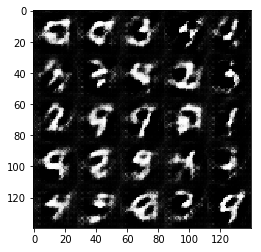

Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 3.0698
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 0.9134
Epoch 1/2... Discriminator Loss: 0.8544... Generator Loss: 1.1889
Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 0.9901
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 1.9983
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 1.7480
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 1.9918
Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 2.2854
Epoch 1/2... Discriminator Loss: 1.0101... Generator Loss: 1.3153


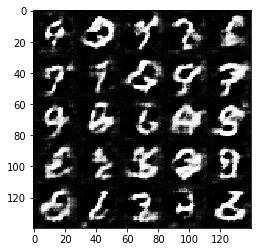

Epoch 1/2... Discriminator Loss: 1.1347... Generator Loss: 2.4435
Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 0.9135
Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 0.8935
Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 1.5382
Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 1.0755
Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 1.6774
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 2.0848
Epoch 2/2... Discriminator Loss: 0.9229... Generator Loss: 1.3891
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 1.2779


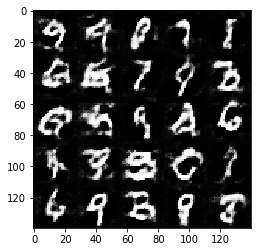

Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.0928
Epoch 2/2... Discriminator Loss: 0.9232... Generator Loss: 1.1903
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 0.6509
Epoch 2/2... Discriminator Loss: 1.0206... Generator Loss: 1.0325
Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: 1.8405
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 1.0048
Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 2.2915
Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 1.2460
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 1.2408
Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 1.0306


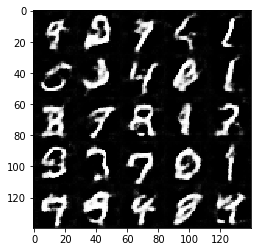

Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 1.6140
Epoch 2/2... Discriminator Loss: 1.2384... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.0613
Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 0.9075
Epoch 2/2... Discriminator Loss: 1.2843... Generator Loss: 2.2914
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 1.1219
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 0.7281
Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 1.0834
Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 1.5883
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.8777


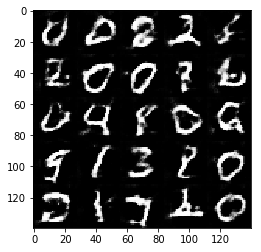

Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 2.2626
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 1.2584
Epoch 2/2... Discriminator Loss: 1.6816... Generator Loss: 2.6267
Epoch 2/2... Discriminator Loss: 0.9201... Generator Loss: 1.1180
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 0.9354
Epoch 2/2... Discriminator Loss: 1.0857... Generator Loss: 0.8048
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 0.5815
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 1.5399
Epoch 2/2... Discriminator Loss: 1.7008... Generator Loss: 2.9289


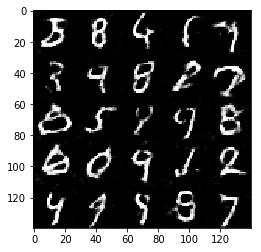

Epoch 2/2... Discriminator Loss: 0.9373... Generator Loss: 1.2514
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 1.5887
Epoch 2/2... Discriminator Loss: 0.8527... Generator Loss: 1.3037
Epoch 2/2... Discriminator Loss: 1.1209... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 1.8044
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 1.2147
Epoch 2/2... Discriminator Loss: 0.9777... Generator Loss: 1.2342
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 1.0410
Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 0.8934
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 1.0193


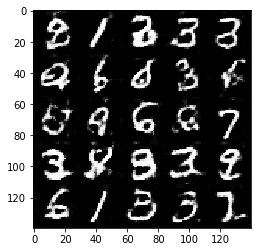

Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 0.9632
Epoch 2/2... Discriminator Loss: 0.9005... Generator Loss: 1.4131
Epoch 2/2... Discriminator Loss: 1.0578... Generator Loss: 0.7906

generator output after trainings


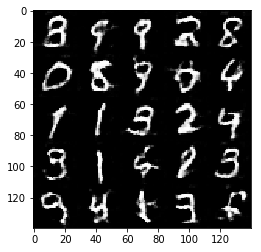

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 2.0920
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 2.2198
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 2.0019
Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 8.4046
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 10.6479
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.5544
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 2.4678


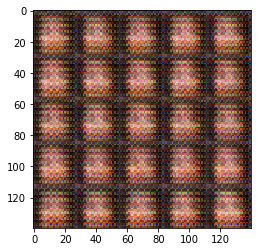

Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 4.2508
Epoch 1/1... Discriminator Loss: 0.4721... Generator Loss: 3.0530
Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 2.9981
Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 2.9432
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 2.6090
Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 3.1086
Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 2.8510
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 3.1114
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 3.1779
Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 1.5953


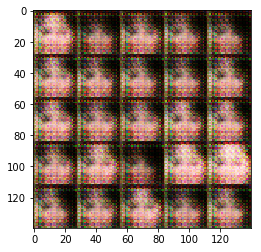

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 2.7691
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.7384
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 2.7186
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 2.7564
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 7.1937
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 1.9129
Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 2.7423
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 3.9990
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 3.7001


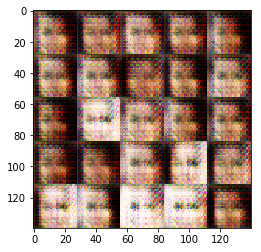

Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 3.4763
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 1.4558
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.4448
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 3.2526
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 2.5540
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 1.4487


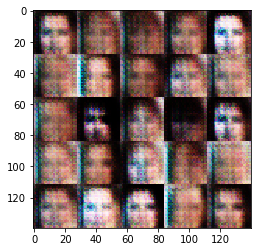

Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.9305
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 2.2297
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.4444
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.2815
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.4836
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.5112
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 2.1783
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.3418


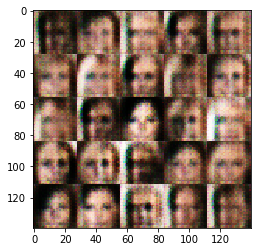

Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 2.0264
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.4474
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 1.8937
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.5622
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.2563


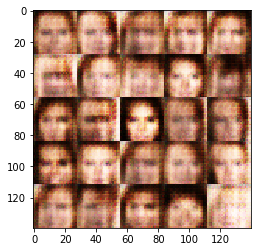

Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.8111
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 3.3001
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.3882
Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 0.4497
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.2843
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.5734
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 1.5017
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.6405
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 2.3502


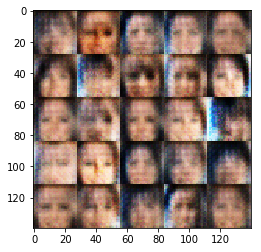

Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.9334
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.5009
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.6230
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.6359
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.0530


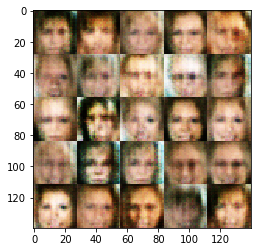

Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.2186
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.5915
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 1.9007
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.3032
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 2.2695


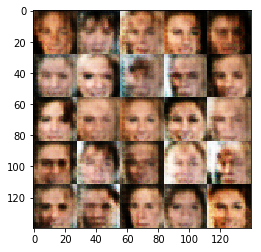

Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.4526
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.8992
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.5501
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 1.7521
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.0623


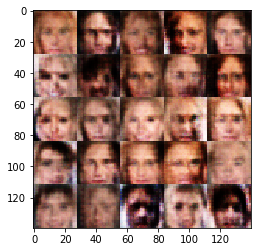

Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.1517
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.5353
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.4723
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.4673


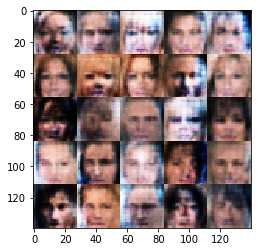

Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 1.3984
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.5511
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 1.5339
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.5081


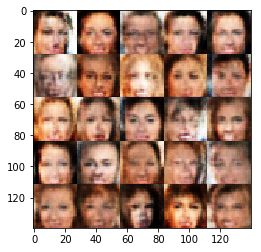

Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.4255
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.4180
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 1.4372


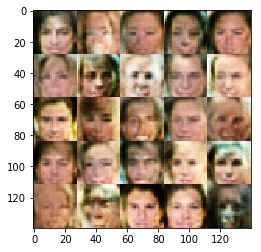

Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 2.0175
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 2.5496
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.7924
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.5866


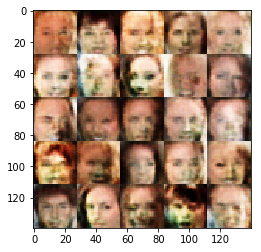

Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.5507
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.6970
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.9429
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 2.1626
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.8182
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 2.2561


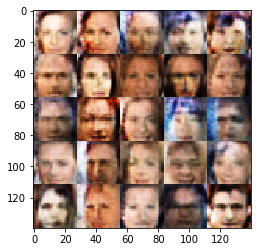

Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 2.1224
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.2464
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 1.7008
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 2.6293
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.6210

generator output after trainings


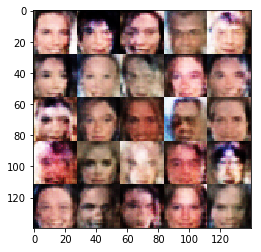

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.